# aSPEM Experiment : analysis

In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

## find best h

In [5]:
def best_h(exp, max_tau) :

    # see notebook dev/2019_07_10_test_harzardrate
    def pred_score(o, p_hat):
        score = o * np.log2(p_hat) + (1-o) * np.log2(1-p_hat)
        return score

    best_h = []
    
    N_blocks = exp['N_blocks']
    p = exp['p']
    tau = np.arange(1, max_tau, 1)
    hs = 1/tau
    
    for i_block in range(N_blocks):
        score = []
        
        o = p[:, i_block, 0] # observations
        p_true = p[:, i_block, 1]

        for i_scan, h_ in enumerate(hs):

            p_hat = np.zeros(200)

            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(o[liste[a]:liste[a+1]], h=h_)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')

                p_hat[liste[a]:liste[a+1]] = p_hat_p

            score.append(np.mean(pred_score(o, p_hat)))
        
        best_h.append(hs[np.argmax(score)])
        
    return best_h

In [6]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [7]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [8]:
def print_stat(h) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
              #'\nwasserstein_distance (Earth movers distance) : ',
              #stats.wasserstein_distance(h['F'], h['M'], u_weights=r['F'], v_weights=r['M']), sep='')
        return man, kr, ks
    
    list_signi = []
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('B %s-%s'%(b1,b2)) ; break
    print('\nSignificatif :', list_signi)

In [9]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

In [10]:
10**1.2

15.848931924611133

In [11]:
fig_width_f = fig_width/2
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200], pourcentage=None, ls=None, v_line_supp=None) :
    
    from matplotlib.patches import Polygon
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    #COLOR = ['b', 'r', 'k', 'g', 'm', 'c', 'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']
    c_block = ['olive', 'peru', 'brown']
    
    
    fig = plt.figure(figsize=(fig_width_f,fig_width_f))
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(5, 5, figure=fig, left=0.1, bottom=0.1, right=1, top=1,
                           wspace=0.1, hspace=0.1)
    ax_ = plt.subplot(gs[1:, :4])
    ax_xC, ax_yC  = plt.subplot(gs[0, :4]), plt.subplot(gs[1:, 4])
    
    
    # DECO
    #---------------------------------------------------------------
    lim = (0.005, 15) #(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    ax_x, ax_y = ax_xC.twinx(), ax_yC.twiny()
    
    lim = (np.log(0.005), np.log(15)) #(np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
    for a in [ax_x, ax_xC] : a.set_xlim(lim) ; a.set_xticks(())
    for a in [ax_y, ax_yC] : a.set_ylim(lim) ; a.set_yticks(())
    ax_xC.set_ylim(0,1.05); ax_yC.set_xlim(0,1.05)
    
    # LABEL
    ax_.set_xlabel('h$_{va}$', fontsize=t_label) ; ax_.set_ylabel('h$_{bet}$', labelpad=-20, fontsize=t_label)
    opt = dict(fontsize=t_label/2.7)
    
    
    ax_xC.set_ylabel('cumulative', **opt)
    ax_yC.set_xlabel('cumulative', **opt) 
    opt['color'] = 'dimgrey'
    ax_x.set_ylabel('density of h$_{va}$', va='bottom', rotation=270, **opt)
    ax_y.set_xlabel('density of h$_{bet}$', va='bottom', **opt) 
    
    for a in [ax_, ax_x, ax_xC, ax_y, ax_yC] : a.set_title('', fontsize=0)
    
    # tick
    ax_.tick_params(labelsize=t_label/2.7, length=7, which='major') ; ax_.tick_params(length=5, which='minor')
    
    opt = dict(labelsize=t_label/2.7)
    for a in [ax_x, ax_xC, ax_y, ax_yC] : a.tick_params(**opt)
    ax_x.set_yticks(())                    ; ax_y.set_xticks(())
    ax_xC.set_yticks((0,0.5,1))            ; ax_yC.set_xticks((0,0.5,1))
    ax_xC.set_yticklabels(('0','0.5','1')) ; ax_yC.set_xticklabels(('0','0.5','1'))
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = {}, {}, {}, {}
    for l in [h_va, h_bet, r_va, r_bet] : l['full'], l['b'] = [], [[],[],[]]
    
    v_l = np.array(v_line_supp['lines'])
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        for d, c in enumerate(range(0, 3*200-150, 200)) :
            r_va_d, r_bet_d = recording['r_va'][s][d][:max_tau], recording['r_bet'][s][d][:max_tau]

            if pourcentage is not None :
                #pourcentage
                #-----------------------------------------------------------------------
                if np.argmax(r_va_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_va_d, pourcentage)
                    r_va_s.append(r_va_d[maxx]) ; h_va_s.append(list_h[maxx])
                else : r_va_s.append(np.max(r_va_d)) ; h_va_s.append(list_h[np.argmax(r_va_d)]/v_l[d])

                if np.argmax(r_bet_d)==len(list_h)-1 :
                    maxx = maxx_pourcentage(r_bet_d, pourcentage)
                    r_bet_s.append(r_bet_d[maxx])   ; h_bet_s.append(list_h[maxx])
                else : r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)]/v_l[d])
                #-----------------------------------------------------------------------
            else :
                r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)]/v_l[d])
                r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)]/v_l[d])
                
            h_va['b'][d].append(h_va_s[d]) ; h_bet['b'][d].append(h_bet_s[d])
            r_va['b'][d].append(r_va_s[d]) ; r_bet['b'][d].append(r_bet_s[d])
        
        #-----------------------------------------------------------------------
        # TRIANGLE
        tritri = np.array([[h_va_s[y], h_bet_s[y]] for y in range(len(h_va_s))])
        popo = Polygon(tritri, edgecolor='k', alpha=0.4, lw=1,
                       ls=ls[num] if ls is not None else '-', facecolor='none') # color=COLOR[num]  
        ax_.add_artist(popo)
        
        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.6, lw=0, edgecolors='k') # c=COLOR[num], lw=3
        
        if s in ['TN', 'LB'] :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*1000,
                        marker='*', c=c_block[:1], zorder=100, lw=0.2, edgecolors='k')
        else :
            ax_.scatter(h_va_s[:1], h_bet_s[:1], s=(np.array(r_va_s[:1])*np.array(r_bet_s[:1]))*600,
                        c=c_block[:1], zorder=50, **opt)

        ax_.scatter(h_va_s[1:], h_bet_s[1:], s=(np.array(r_va_s[1:])*np.array(r_bet_s[1:]))*600,
                    c=c_block[1:], zorder=50, **opt)
        
        #-----------------------------------------------------------------------
        h_va['full'].extend(h_va_s) ; h_bet['full'].extend(h_bet_s)
        r_va['full'].extend(r_va_s) ; r_bet['full'].extend(r_bet_s)
    
    h_va['full'], h_bet['full'], r_va['full'], r_bet['full'] = mask_nan(h_va['full'], h_bet['full'], r_va['full'], r_bet['full'])
    r_va['full'], r_bet['full'] = np.array(r_va['full']), np.array(r_bet['full'])

    #--------------------------------------------------------------------------------------------
    # HISTOGRAMME
    #--------------------------------------------------------------------------------------------
    lim = (np.log(0.005), np.log(15))
    
    opt = dict(range=lim, bins=20)#, alpha=0.3)
    opt_c = dict(range=lim,
                 bins=len(list_h), cumulative=True, histtype='step', align='mid', lw=2, density=True)
    
    # hist VA
    #--------------------------------------------------------------------
    for a, o, c in zip([ax_x, ax_xC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_va['full']), color=c, label='Full', alpha=0.3 if o==opt else 1, **o)
        a.hist([np.log(h_va['b'][0]), np.log(h_va['b'][1]), np.log(h_va['b'][2])],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o)
    # hist BET
    #--------------------------------------------------------------------
    opt['orientation'], opt_c['orientation'] = "horizontal", "horizontal"
    for a, o, c in zip([ax_y, ax_yC], [opt, opt_c], ['dimgrey', 'k']) :
        a.hist(np.log(h_bet['full']), color=c, label='Full', alpha=0.3 if o==opt else 1, **o)
        a.hist([np.log(h_bet['b'][0]), np.log(h_bet['b'][1]), np.log(h_bet['b'][2])],
               color=c_block, label=['block 1', 'block 2', 'block 3'],
               alpha=0.6 if o==opt else 1, **o)
    
    # lines
    #--------------------------------------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.5, lw=1.5)
    opt=dict(colors='teal', linestyles='-', alpha=0.7, linewidth=1.5)
    ax_.vlines(0.025, -10, 10, label='h$_{true}$', **opt) ; ax_.hlines(0.025, -10, 10, **opt)
    ax_xC.vlines(np.log(0.025), 0, 1.1, **opt) ; ax_yC.hlines(np.log(0.025), 0, 1.1, **opt)
    
    #lim = [np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10)]
    lim = (np.log(0.003), np.log(15))
    ax_xC.hlines(0.5, lim[1], lim[0], colors='k', alpha=0.5, linewidth=1)
    ax_yC.vlines(0.5, lim[1], lim[0], colors='k', alpha=0.5, linewidth=1)
    
    
    
    opt_legend = dict(alpha=0.7, lw=15, colors='k')
    ax_.vlines(0, 0, 0, label='Full', **opt_legend)
    
    mimi_va, mimi_bet = np.nanmedian(h_va['full']), np.nanmedian(h_bet['full'])
    
    
    opt=dict(colors='k', alpha=0.8, lw=1.5, linestyles=(3.5,[4, 2, 4, 2]))
    ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
    ax_xC.vlines(np.log(mimi_va), 0, 1.1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1.1, **opt)
    
    for b, c in enumerate(c_block) :
        opt['colors'] = c
        opt_legend['colors'] = c
        mimi_va, mimi_bet = np.nanmedian(h_va['b'][b]), np.nanmedian(h_bet['b'][b])
        
        print('\nBLOCK %s'%(b), end=' :\t\t')
        print('\nVA\tmedian', np.nanmedian(h_va['b'][b]),
             '\nBET\tmedian', np.nanmedian(h_bet['b'][b]))
        
        ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt)
        ax_xC.vlines(np.log(mimi_va), 0, 1.1, **opt) ; ax_yC.hlines(np.log(mimi_bet), 0, 1.1, **opt)
        
        ax_.vlines(0, 0, 0, label='block %s'%(b+1), **opt_legend)
    
    opt=dict(alpha=0.8, lw=1.5, colors='k')
    ax_.vlines(1, 0, 10, **opt) ; ax_.hlines(1, 0, 10, **opt)
    ax_xC.vlines(np.log(1), 0, 1.1, **opt) ; ax_yC.hlines(np.log(1), 0, 1.1, **opt)
    
    #--------------------------------------------------------------------
    # Legend
    opt_l = dict(fontsize=t_label/2.7, framealpha=0)#, handlelength=0.6, handletextpad=0.2)
    ax_.legend(loc=2, bbox_to_anchor=(0.05, 0.95, 0., 0.) ,**opt_l)
    #--------------------------------------------------------------------------------------------
    
    plt.show()
    
    #--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    from scipy import stats
    print('h_va/h_bet :', stats.wilcoxon(h_va['full'], h_bet['full']))
    _, _, r, _, _ = stats.linregress(h_va['full'], h_bet['full'])
    print('h_va/h_bet : r =', r)
    
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], ['h_va', 'h_bet']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        h['full'] = list(h['full'])
        print('median', np.nanmedian(h['full']),
              '\n25%', np.quantile(h['full'], 0.25),
              '\n75%', np.quantile(h['full'], 0.75))
        print_stat(h)
    #--------------------------------------------------------------------------------------------
    
    return fig

In [12]:
file = os.path.join('../parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')

In [13]:
max_tau=1601

In [14]:
import glob
import pickle
for fname in glob.glob('data/pari*pkl'):
    l = fname.split('/')[1].split('.')[0].split('_')
    if l[1]=='AM' :
        a = 'data/pari_AM_%s.pkl'%(l[2]+'_'+l[3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp = b

v_line_supp = {}
v_line_supp['colors'] = ['olive', 'peru', 'brown']
v_line_supp['lines'] = best_h(exp, max_tau)

In [15]:
ls =   [(0,[3*i,2,3*i,2]) for i in range(1, 13)]
opt = dict(max_tau=max_tau, ls=ls)

In [16]:
print(v_line_supp['lines'])

[0.05555555555555555, 0.041666666666666664, 0.07692307692307693]


AM BMC CS DC FM IP LB OP RS SR TN YK 
BLOCK 0 :		
VA	median 1.0285714285714285 
BET	median 0.31370192307692313

BLOCK 1 :		
VA	median 1.263157894736842 
BET	median 0.632016632016632

BLOCK 2 :		
VA	median 1.240909090909091 
BET	median 0.5121212121212121


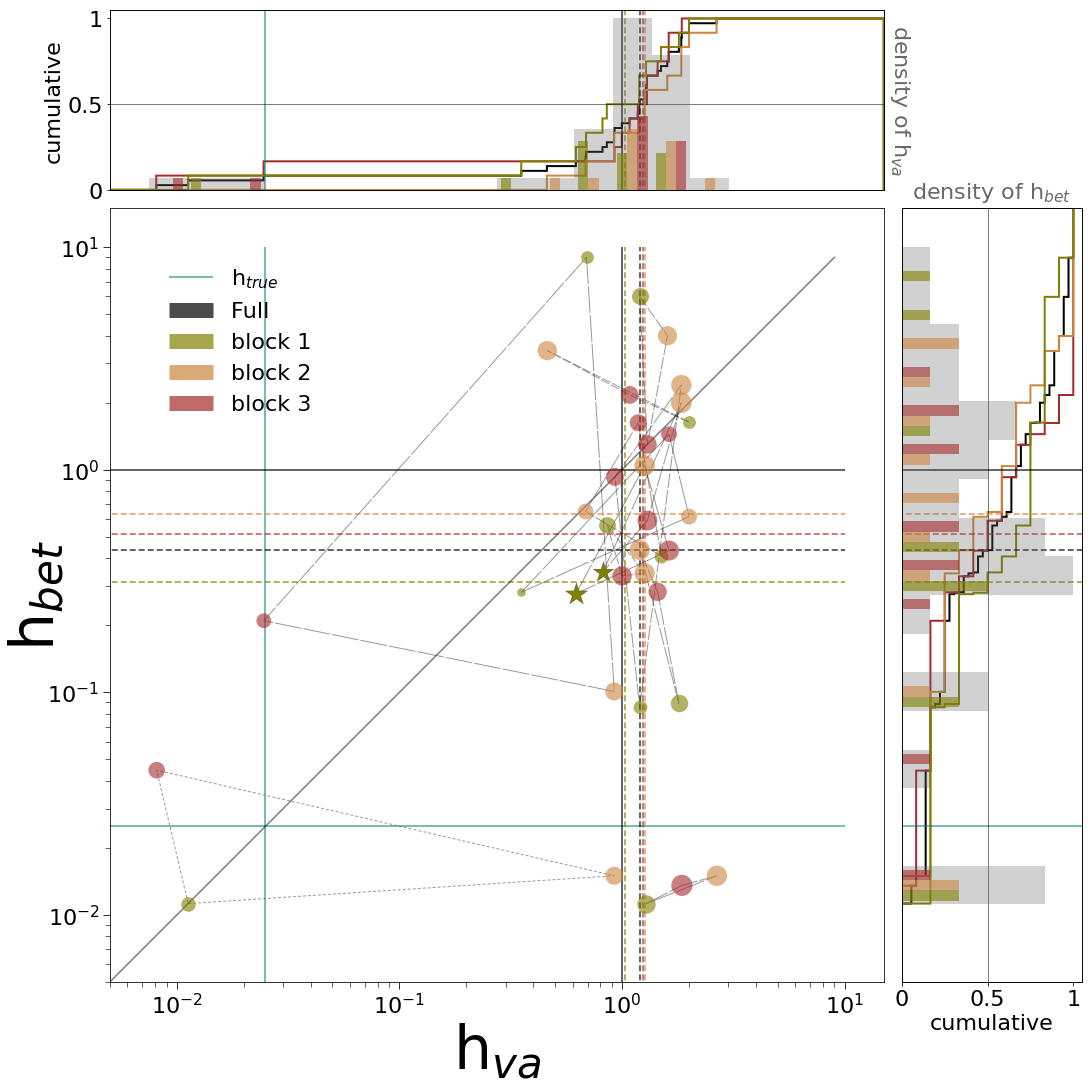

h_va/h_bet : WilcoxonResult(statistic=180.0, pvalue=0.07253956398434629)
h_va/h_bet : r = -0.013896192299472749


----------------------------------------------------------------
h_va
----------------------------------------------------------------
median 1.2000000000000002 
25% 0.8474025974025974 
75% 1.6062500000000002

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.0827		0.1568		0.5361
BLOCK 0 vs 2 :		0.2721		0.5251		0.5361
BLOCK 1 vs 2 :		0.3116		0.6029		0.8690

Significatif : []


----------------------------------------------------------------
h_bet
----------------------------------------------------------------
median 0.4348484848484848 
25% 0.18246814854974244 
75% 1.489583333333333

			mannwhitneyu	kruskal		ks_2samp
			------------	-------		--------
BLOCK 0 vs 1 :		0.1703		0.3261		0.5361
BLOCK 0 vs 2 :		0.2721		0.5253		0.8690
BLOCK 1 vs 2 :		0.2533		0.4883		0.8690

Significatif : []


In [17]:
fig = plot_fig(recording, v_line_supp=v_line_supp,  **opt)